In [230]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

In [157]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,14,16,17,19,19,19,19,19,19,19


In [158]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [159]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [160]:
df_wdi = pd.read_csv('datasets/world_development_index_clean.csv')

In [161]:
df_wdi.head()

,Country Name,"Birth rate (per 1,000)","Death, by communicable diseases and others (%)","Death, by non-communicable diseases (%)","Health expenditure per capita, PPP ($)","Death rate (per 1,000)","Hospital beds (per 1,000)","International tourism, number of arrivals",Life expectancy at birth (years),"Mortality rate, adult, female (per 1,000)","Mortality rate, adult, male (per 1,000)","Nurses and midwives (per 1,000)",People using at least basic sanitation services (%),Population ages 65+ (%),Population density (people per sq.km),Population,Smoking prevalence (ages 15+)
0,Hungary,9.700,1.8,93.8,1963.162630,13.500,7.000000,17552000.0,76.063415,80.586,168.058,6.6425,97.990873,19.157725,107.906606,9768785.0,30.6
1,Colombia,15.098,10.1,74.8,829.802922,5.503,1.500000,3904000.0,76.925000,87.205,187.406,1.2627,89.625358,8.478047,44.748702,49648685.0,9.0
2,Germany,9.500,4.8,91.2,5463.330652,11.300,8.300000,38881000.0,80.990244,50.173,92.460,13.1967,99.225038,21.461962,237.370970,82927922.0,30.6
3,Slovenia,9.800,5.0,88.4,2772.229776,9.900,4.600000,4425000.0,81.175610,43.961,94.604,9.6800,99.109568,19.606880,102.639860,2067372.0,22.5
4,Rwanda,32.062,42.4,44.0,130.380629,5.308,0.661133,932000.0,68.341000,164.756,219.354,0.8307,66.573842,2.938196,498.659870,12301939.0,12.3


In [162]:
# df = df.join(df_wdi.set_index('Country Name'), on='Country/Region').dropna()

In [163]:
# cols = df.columns[4:]

In [164]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


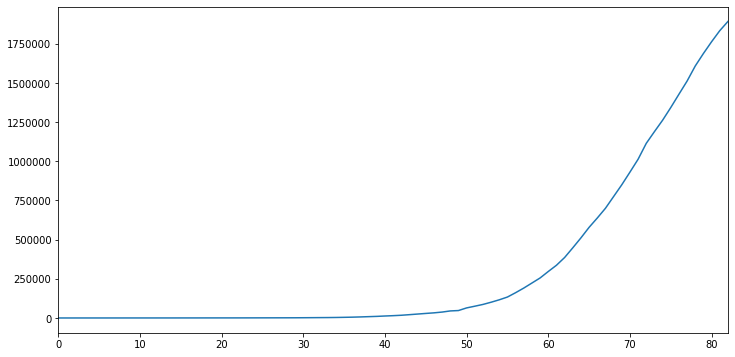

In [165]:
df['Confirmed'].plot(figsize=(12,6))

In [166]:
# df = df.dropna()

In [167]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [168]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [169]:
training_set = df[:train_index]

In [170]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [171]:
training_set_scaled.shape

(66, 1)

In [172]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [173]:
print(X_train.shape, y_train.shape)

(46, 20, 1) (46,)


In [174]:
# X_train[0]

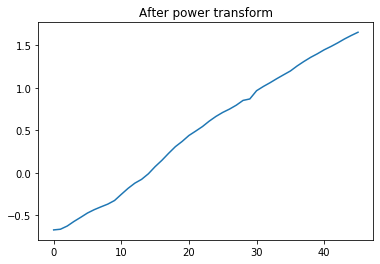

In [175]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [176]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
66,2020-03-29,638018,67
67,2020-03-30,700191,68
68,2020-03-31,775208,69
69,2020-04-01,850244,70
70,2020-04-02,931034,71


In [177]:
real_conf = testing_set['Confirmed'].values

In [178]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [179]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [180]:
# inputs
# total
print(X_test.shape)

(17, 20, 1)


In [181]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [182]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [183]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [184]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [185]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 41 samples, validate on 5 samples
Epoch 1/200
41/41 [==============================] - 0s 8ms/step - loss: 0.5847 - val_loss: 0.5661
Epoch 2/200
41/41 [==============================] - 0s 2ms/step - loss: 0.3889 - val_loss: 0.2416
Epoch 3/200
41/41 [==============================] - 0s 2ms/step - loss: 0.3174 - val_loss: 0.2336
Epoch 4/200
41/41 [==============================] - 0s 2ms/step - loss: 0.2306 - val_loss: 0.2124
Epoch 5/200
41/41 [==============================] - 0s 2ms/step - loss: 0.2175 - val_loss: 0.1284
Epoch 6/200
41/41 [==============================] - 0s 2ms/step - loss: 0.1637 - val_loss: 0.0143
Epoch 7/200
41/41 [==============================] - 0s 2ms/step - loss: 0.1253 - val_loss: 0.1256
Epoch 8/200
41/41 [==============================] - 0s 2ms/step - loss: 0.1562 - val_loss: 0.0931
Epoch 9/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0889 - val_loss: 0.0708
Epoch 10/200
41/41 [==============================] - 0s 2ms/step 

41/41 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0210

Epoch 00071: ReduceLROnPlateau reducing learning rate to 4.747560842588427e-06.
Epoch 72/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0210
Epoch 73/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0210
Epoch 74/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0211
Epoch 75/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0213

Epoch 00075: ReduceLROnPlateau reducing learning rate to 3.3232926853088427e-06.
Epoch 76/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0214
Epoch 77/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0215
Epoch 78/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0215
Epoch 79/200
41/41 [==============================

41/41 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0206
Epoch 139/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0206

Epoch 00139: ReduceLROnPlateau reducing learning rate to 1.1044275005644976e-08.
Epoch 140/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0206
Epoch 141/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0206
Epoch 142/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0206
Epoch 143/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0206

Epoch 00143: ReduceLROnPlateau reducing learning rate to 7.730992379606505e-09.
Epoch 144/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0206
Epoch 145/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0206
Epoch 146/200
41/41 [======================

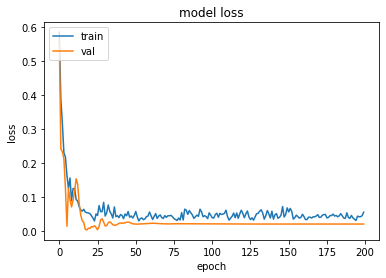

In [186]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [187]:
model.load_weights("model.h5")

In [188]:
predicted_conf = model.predict(X_test)

In [189]:
# predicted_conf=pd.DataFrame(predicted_conf)
# X_test[0]

In [190]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[ 629950.75],
       [ 706102.1 ],
       [ 785103.9 ],
       [ 866203.56],
       [ 949029.  ],
       [1033234.56],
       [1118654.4 ],
       [1206520.4 ],
       [1295838.1 ],
       [1384340.8 ],
       [1470990.1 ],
       [1555698.6 ],
       [1638619.1 ],
       [1720875.  ],
       [1802409.6 ],
       [1882100.  ],
       [1958856.5 ]], dtype=float32)

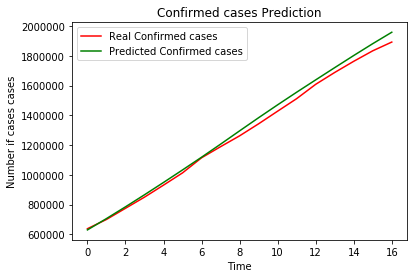

In [191]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [192]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([ 638018,  700191,  775208,  850244,  931034, 1013406, 1114865,
       1189513, 1262436, 1343378, 1428295, 1512467, 1608778, 1688500,
       1763545, 1834106, 1892885], dtype=int64)

In [193]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.02163174871172695


# Use old predictions as input for new predictions

In [194]:
training_set.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [195]:
inp = np.array([X_train[-1]])
inp

array([[[0.71060513],
        [0.74967588],
        [0.79548162],
        [0.85172221],
        [0.86884243],
        [0.96597694],
        [1.01571526],
        [1.06032424],
        [1.10816911],
        [1.15350041],
        [1.19821017],
        [1.25741047],
        [1.31011778],
        [1.35891329],
        [1.40109958],
        [1.44764947],
        [1.48665959],
        [1.52922301],
        [1.57514689],
        [1.61609816]]])

In [196]:
inp_pred = model.predict(inp)

In [197]:
inp_pred[0]

array([1.643242], dtype=float32)

In [198]:
inp = list(inp[0])
inp.pop(0)

array([0.71060513])

In [199]:
inp.append(inp_pred)
# inp

In [200]:
# np.array([inp])

In [201]:
def gen_pred(inp, num):
    preds = []
    for n in range(num):     
        inp = np.array([inp])
        inp_pred = model.predict(inp) 
        preds.append(list(inp_pred[0]))
        inp = list(inp[0])
        inp.pop(0)
        inp.append(inp_pred)
    return preds


In [221]:
res = gen_pred(X_train[-1], len(real_conf))
# res

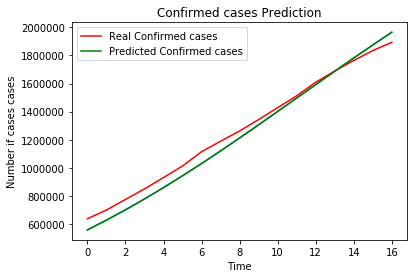

In [222]:
plt.plot(sc.inverse_transform(res))

plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(res), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

plt.show()

In [223]:
print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(sc.inverse_transform(res) + 1) - np.log(real_conf + 1)))))

RMSLE =  0.5136938049690107


# For each country

In [224]:
# pop = pd.read_csv('datasets\population_data.csv')
# pop.head()

In [225]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [41]:
country ='India'

In [42]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0).reset_index()
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
0,1373,India,21.0,78.0,2020-01-30,1
1,1558,India,21.0,78.0,2020-01-31,1
2,1743,India,21.0,78.0,2020-02-01,1
3,1928,India,21.0,78.0,2020-02-02,2
4,2113,India,21.0,78.0,2020-02-03,3


In [43]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
71,14508,India,21.0,78.0,2020-04-10,7598,72
72,14693,India,21.0,78.0,2020-04-11,8446,73
73,14878,India,21.0,78.0,2020-04-12,9205,74
74,15063,India,21.0,78.0,2020-04-13,10453,75
75,15248,India,21.0,78.0,2020-04-14,11487,76


In [44]:
wdi_cols = df_wdi.columns

In [45]:
wdi_cols

Index(['Country Name', 'Birth rate (per 1,000)',
       'Death, by communicable diseases and others (%)',
       'Death, by non-communicable diseases (%)',
       'Health expenditure per capita, PPP ($)', 'Death rate (per 1,000)',
       'Hospital beds (per 1,000)',
       'International tourism, number of arrivals',
       'Life expectancy at birth (years)',
       'Mortality rate, adult, female (per 1,000)',
       'Mortality rate, adult, male (per 1,000)',
       'Nurses and midwives (per 1,000)',
       'People using at least basic sanitation services (%)',
       'Population ages 65+ (%)', 'Population density (people per sq.km)',
       'Population', 'Smoking prevalence (ages 15+)'],
      dtype='object')

In [217]:
# df_wdi['Birth rate (per 1,000)'] * (df_wdi['Population']/1000)
# df_wdi['Death rate (per 1,000)'] * (df_wdi['Population']/1000)
# df_wdi['Hospital beds (per 1,000)'] * (df_wdi['Population']/1000)
# df_wdi['Nurses and midwives (per 1,000)'] * (df_wdi['Population']/1000)



In [219]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [220]:
training = split
total = temp.shape[0]
train_index = int(total*training)
total

76

In [49]:
training_set = temp[:train_index]

In [50]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [51]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [52]:
print(X_train.shape, y_train.shape)

(42, 18, 1) (42,)


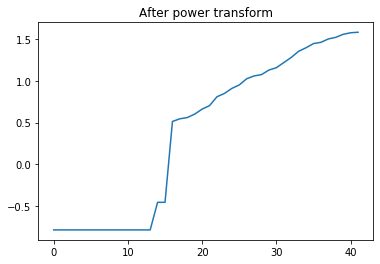

In [53]:
# X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [54]:
testing_set = temp[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
60,12473,India,21.0,78.0,2020-03-30,1251,61
61,12658,India,21.0,78.0,2020-03-31,1397,62
62,12843,India,21.0,78.0,2020-04-01,1998,63
63,13028,India,21.0,78.0,2020-04-02,2543,64
64,13213,India,21.0,78.0,2020-04-03,2567,65


In [55]:
real_conf = testing_set['Confirmed'].values

In [56]:
# test_set=testing_set['Confirmed']
# test_set=pd.DataFrame(test_set)


In [57]:
inputs = temp['Confirmed'][len(temp) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [58]:
# inputs
# total

In [59]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))
# Y_test

In [60]:
print(X_test.shape, Y_test.shape)

(16, 18, 1) (16, 1)


In [61]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [231]:
def create_model():
    model = Sequential()

    model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)
    
    return model

In [233]:
plat = ReduceLROnPlateau(monitor='loss', patience=4, verbose=0, factor=0.7)
cb = [plat]

In [ ]:
model = create_model()

In [64]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
                    verbose = 0,
                    validation_split = 0.1)

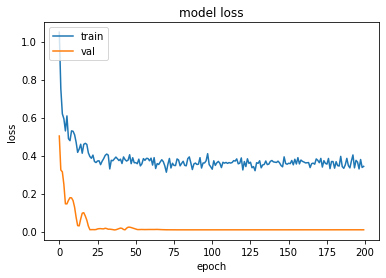

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [66]:
# model.load_weights("model.h5")

In [67]:
predicted_conf = model.predict(X_test)

In [68]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.91129667],
       [0.95294642],
       [1.02758677],
       [1.06106791],
       [1.07761719],
       [1.13234812],
       [1.16037096],
       [1.22251824],
       [1.28382853],
       [1.35861341],
       [1.4007092 ],
       [1.45098316],
       [1.4658652 ],
       [1.50655842],
       [1.52591723],
       [1.56232732],
       [1.58102525],
       [1.58733283]])

In [69]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
real_conf

array([ 1251,  1397,  1998,  2543,  2567,  3082,  3588,  4778,  5311,
        5916,  6725,  7598,  8446,  9205, 10453, 11487], dtype=int64)

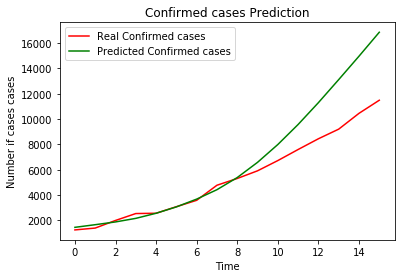

In [70]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [71]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
pred_conf
real_conf

array([ 1251,  1397,  1998,  2543,  2567,  3082,  3588,  4778,  5311,
        5916,  6725,  7598,  8446,  9205, 10453, 11487], dtype=int64)

In [72]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.2046032949223789


In [228]:
countries = list(df_c['Country/Region'].unique())
len(countries)

184

In [ ]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [240]:
errs = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    training = split
    total = temp.shape[0]
    train_index = int(total*training)
    
    training_set = temp[:train_index]
    
    sc = PowerTransformer(method='yeo-johnson', standardize=True)
    training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))
    
    X_train = []
    y_train = []
    for i in range(window, train_index):
        X_train.append(training_set_scaled[i-window:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping
    if X_train.shape[0] < 1:
        continue
    print(X_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    testing_set = temp[train_index:]
    testing_set = pd.DataFrame(testing_set)
    
    inputs = temp['Confirmed'][len(temp) - len(testing_set) - window:].values
    # print(inputs)
    inputs = inputs.reshape(-1,1)
    # print(inputs)
    inputs = sc.transform(inputs)
    # print(inputs)
    X_test = []
    for i in range(window, window+(total-train_index)):
        X_test.append(inputs[i-window:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))
    
    model = create_model()
    
    history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
                    verbose = 0)
    
    predicted_conf = model.predict(X_test)    
    pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
    real_conf = np.array(testing_set['Confirmed'].values)
    
    rmsle = np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1))))
    
    errs.append([country ,rmsle])
    
    
    

(20, 20)
(9, 20)
(20, 20)
(15, 20)
(6, 20)
(14, 20)
(16, 20)
(44, 20)
(20, 20)
(16, 20)
(4, 20)
(20, 20)
(10, 20)
(3, 20)
(17, 20)
(36, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(4, 20)
(12, 20)
(8, 20)
(12, 20)
(19, 20)
(9, 20)
(10, 20)
(8, 20)
(43, 20)
(12, 20)
(44, 20)
(4, 20)
(1, 20)
(14, 20)
(12, 20)
(4, 20)
(8, 20)
(12, 20)
(8, 20)
(20, 20)
(7, 20)
(9, 20)
(16, 20)
(18, 20)
(34, 20)
(2, 20)
(16, 20)
(16, 20)
(28, 20)
(1, 20)
(4, 20)
(18, 20)
(5, 20)
(6, 20)
(1, 20)
(41, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(45, 20)
(5, 20)
(3, 20)
(19, 20)
(43, 20)
(5, 20)
(19, 20)
(5, 20)
(6, 20)
(7, 20)
(12, 20)
(8, 20)
(13, 20)
(17, 20)
(40, 20)
(15, 20)
(24, 20)
(20, 20)
(16, 20)
(23, 20)
(40, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(8, 20)
(46, 20)
(14, 20)
(6, 20)
(6, 20)
(46, 20)
(20, 20)
(2, 20)
(15, 20)
(23, 20)
(4, 20)
(13, 20)
(17, 20)
(16, 20)
(44, 20)
(10, 20)
(11, 20)
(5, 20)
(2, 20)
(17, 20)
(10, 20)
(16, 20)
(8, 20)
(3, 20)
(15, 20)
(5, 20)
(44, 20)
(18, 20)
(17, 20)
(1, 20)
(17, 20)
(19, 20)
(19, 20)
(20, 20)
(19, 20)
(8, 20)
(10, 20)
(12, 20)
(40, 20)
(13, 20)
(15, 20)
(16, 20)
(19, 20)
(40, 20)
(5, 20)
(5, 20)
(5, 20)
(18, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(15, 20)
(15, 20)
(12, 20)
(5, 20)
(46, 20)
(12, 20)
(12, 20)
(4, 20)
(12, 20)
(39, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(43, 20)
(6, 20)
(5, 20)
(40, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)


(20, 20)
(46, 20)
(4, 20)
(46, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(12, 20)
(5, 20)
(13, 20)
(8, 20)
(46, 20)
(14, 20)
(41, 20)
(40, 20)
(5, 20)
(4, 20)
(5, 20)
(46, 20)
(12, 20)


C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(2, 20)



In [238]:
# np.array(errs).mean()

0.511952284746982

In [241]:
errs

[['Afghanistan', 0.6417250096214753],
 ['Albania', 0.12931728182268848],
 ['Algeria', 0.1246814905031845],
 ['Andorra', 0.025481004103957348],
 ['Antigua and Barbuda', 0.2669516050951911],
 ['Argentina', 0.12003755750284319],
 ['Armenia', 0.3440677205847183],
 ['Australia', 0.3475696469106508],
 ['Austria', 0.2553368697443671],
 ['Azerbaijan', 0.13729216579101033],
 ['Bahamas', 0.19751853033871167],
 ['Bahrain', 0.09262845862286348],
 ['Bangladesh', 0.5265957511103867],
 ['Barbados', 0.05023947087167219],
 ['Belarus', 1.8116549769212151],
 ['Belgium', nan],
 ['Benin', 0.1050753121211302],
 ['Bhutan', 0.14191087751730258],
 ['Bolivia', 0.14062440980433596],
 ['Bosnia and Herzegovina', 0.14672129403071846],
 ['Brazil', 0.13165535191927094],
 ['Brunei', 0.021064905283687783],
 ['Bulgaria', 0.04923764065063732],
 ['Burkina Faso', 0.10019450096582894],
 ['Cambodia', nan],
 ['Cameroon', 1.2692405376366918],
 ['Canada', 0.31863702201577554],
 ['Central African Republic', 0.15546011916299748],